# CA 97-NY flooding event - LARGE SCALE PLOTS

## Load libraries

In [1]:
""" Initialize the notebook. """

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import os
import numpy as np
import time
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from PIL import Image
import dask
from dask.diagnostics import ProgressBar
import pandas as pd
from scipy import interpolate
import cmasher as cmr
from scipy.ndimage import gaussian_filter as gf
import xesmf
import glob
import datetime
import cftime

font = { 'family' : 'serif', 'size' : '10', 'weight' : 'normal'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib
print("{}: Working at {}".format(os.uname()[1], os.getcwd()))
flatten = lambda l: [item for sublist in l for item in sublist]

from Plot_NY97_library import *
%load_ext autoreload
%autoreload 2

ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/i/indah/.conda/envs/climate_py39/share/proj failed


login33: Working at /global/cfs/cdirs/m1517/cascade/indah/RESEARCH/CA_97_NY_future


## Define global variables

### Define file root, cases, resolution, and var files

In [2]:
# Setup folders and regex
root_ens = "./DATA.pl"
cases = ["control", "PI", "plus1K", "plus2K", "plus3K", "plus4K"]
labels = ["Control", "Pre-industrial", "Contemporary", "+1.7$^\circ$C", "+2.5$^\circ$C", "+3.5$^\circ$C"]
resolutions = ["ne0wus30x8", "ne0wus30x16", "ne0wus30x32"]
hfiles = ["eam.h1", "eam.h2", "elm.h0", "IVT", "OMEGA_AND_LCL", ]

### Define fileName function to look for files depending on case, res and variables

In [3]:
fileName = lambda res, case, h, date: glob.glob("{}/*{}*{}*{}*{}*.nc".format(root_ens, res, case, h, date))[0]
mfileName = lambda root, res, case, h: np.sort(glob.glob("{}/ensavg*{}*{}*{}*.nc".format(root, res, case, h)))

### Define start times and start dates

In [4]:
full_dates =  [(1996, 12, 31, 0), (1996, 12, 31, 6), (1996, 12, 31, 12), (1996, 12, 31, 18),
               (1997,  1,  1, 0), (1997,  1,  1, 6), (1997,  1,  1, 12), (1997,  1,  1, 18), 
               (1997,  1,  2, 0), (1997,  1,  2, 6), (1997,  1,  2, 12), (1997,  1,  2, 18),
               (1997,  1,  3, 0), (1997,  1,  3, 6), (1997,  1,  3, 12), (1997,  1,  3, 18)
              ]

start_dates = full_dates[::4]
start_times = [cftime.DatetimeNoLeap(date[0], 
                                     date[1], 
                                     date[2], 
                                     date[3], 
                                     has_year_zero=True) for date in start_dates]
start_times = np.array(start_times)
start_times

array([cftime.DatetimeNoLeap(1996, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 1, 3, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

## Define helper functions

In [5]:
def start_date_to_str(d):
    d = datetime.datetime(d[0], d[1], d[2], d[3])
    date = np.datetime_as_string(np.datetime64(d)).split(":")[0]
    return date

In [6]:
def fill_lev_nans(x):
    """
    """
    x2 = x.rename({"lon":"x", "lat":"y"}).rio.write_crs("epsg:4326", inplace=True)
    x3 = x2.rio.write_crs("epsg:4326", inplace=True)
    x4 = x3.rio.write_nodata(np.nan, inplace=True)
    x5 = x4.rio.interpolate_na().rename({"x":"lon", "y":"lat"})
    return x5

In [7]:
for c in cases:
    print(c)
    print(mfileName("./DATA", "ne0wus30x32", c, "IVT"))
    print()

control
['./DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.IVT.1996-12-31-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.IVT.1997-01-01-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.IVT.1997-01-02-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.IVT.1997-01-03-00.nc']

PI
['./DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.IVT.1996-12-31-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.IVT.1997-01-01-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.IVT.1997-01-02-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.IVT.1997-01-03-00.nc']

plus1K
['./DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-plus1K.IVT.1996-12-31-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-plus1K.IVT.1997-01-01-00.nc'
 './DATA/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-plus1K.IVT.1997-01-02-00.nc'
 './DATA/ensavg.regrid

In [8]:
for c in cases:
    print(c)
    print(mfileName("./DATA.pl", "ne0wus30x32", c, "eam.h2"))
    print()

control
['./DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.eam.h2.1996-12-31-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.eam.h2.1997-01-01-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.eam.h2.1997-01-02-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-control.eam.h2.1997-01-03-00.nc']

PI
['./DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.eam.h2.1996-12-31-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.eam.h2.1997-01-01-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.eam.h2.1997-01-02-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-PI.eam.h2.1997-01-03-00.nc']

plus1K
['./DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-plus1K.eam.h2.1996-12-31-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0wus30x32-101-plus1K.eam.h2.1997-01-01-00.nc'
 './DATA.pl/ensavg.regridded.RoS-F2010CICEROF-ne0w

## Create datasets for plotting

### Load IVT and h1 regridded files

In [9]:
cases

['control', 'PI', 'plus1K', 'plus2K', 'plus3K', 'plus4K']

In [10]:
%%time
dss  = [xr.open_mfdataset(mfileName("./DATA", "ne0wus30x32", c, "IVT"),
                          combine="nested",
                          concat_dim="time")[['WIND_SPEED','WIND_DIRECTION','VERTICAL_INTEGRATE_WIND','VERTICAL_INTEGRATE_Q','IVT']]
        for c in cases]

CPU times: user 293 ms, sys: 149 ms, total: 442 ms
Wall time: 713 ms


In [11]:
dss2 = [xr.open_mfdataset(mfileName("./DATA.pl", "ne0wus30x32", c, "eam.h2"))
        for c in cases]
dss = [d.assign_coords(time=d2.time) for d,d2 in zip(dss,dss2)]    
len(dss), len(dss2)

(6, 6)

In [12]:
dss = xr.concat(dss, dim="case")
dss = dss.assign_coords({"case":cases})
dss.attrs = {}

In [13]:
dss2 = xr.concat(dss2, dim="case")
dss2 = dss2.assign_coords({"case":cases})
dss2.attrs = {}

In [14]:
ds = xr.merge([dss, dss2])
ds = ds.drop_dims("vert")
ds

<xarray.Dataset>
Dimensions:                  (case: 6, time: 4, lat: 441, lon: 1121, lev: 13)
Coordinates:
  * time                     (time) object 1996-12-31 00:00:00 ... 1997-01-03...
  * lon                      (lon) float32 120.0 120.1 120.2 ... 259.9 260.0
  * lat                      (lat) float32 10.0 10.12 10.25 ... 64.75 64.88 65.0
  * case                     (case) <U7 'control' 'PI' ... 'plus3K' 'plus4K'
  * lev                      (lev) float64 1e+03 975.0 950.0 ... 550.0 500.0
Data variables:
    VERTICAL_INTEGRATE_WIND  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 441, 1121), meta=np.ndarray>
    VERTICAL_INTEGRATE_Q     (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 441, 1121), meta=np.ndarray>
    IVT                      (case, time, lat, lon) float32 dask.array<chunksize=(1, 1, 441, 1121), meta=np.ndarray>
    T                        (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 13, 441, 1121), meta=np.ndarray>
    U                        (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 13, 441, 1121), meta=np.ndarray>
    V                        (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 13, 441, 1121), meta=np.ndarray>
    Q                        (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 13, 441, 1121), meta=np.ndarray>
    Z3                       (case, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 13, 441, 1121), meta=np.ndarray>

### Assign time coords to IVT

### Interpolate from sigma to pressure Z, U, and V

### Create difference IVT and orography-extrapolated Z datasets

## Plots

### Large scale IVT

In [15]:
for i in range(4):
    ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
    print(ts)

1996-12-31T00
1997-01-01T00
1997-01-02T00
1997-01-03T00


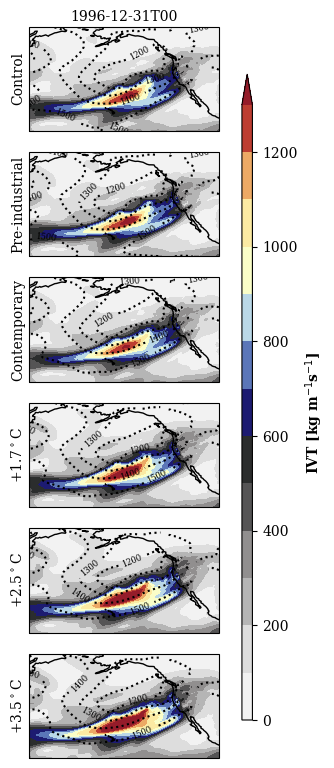

In [16]:
i=0
fig,ts = plot_ivt(ds, start_dates[i], ylabels=labels)
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/IVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

In [17]:
# i=1
# fig,ts = plot_ivt(ds, start_dates[i], ylabels=labels)
# ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
# fig.savefig("plots/IVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

In [18]:
# i=2
# fig,ts = plot_ivt(ds, start_dates[i], ylabels=labels)
# ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
# fig.savefig("plots/IVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

In [19]:
# i=3
# fig,ts = plot_ivt(ds, start_dates[i], ylabels=labels)
# ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
# fig.savefig("plots/IVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

### IVT difference and Z

CPU times: user 19 s, sys: 727 ms, total: 19.7 s
Wall time: 19.1 s


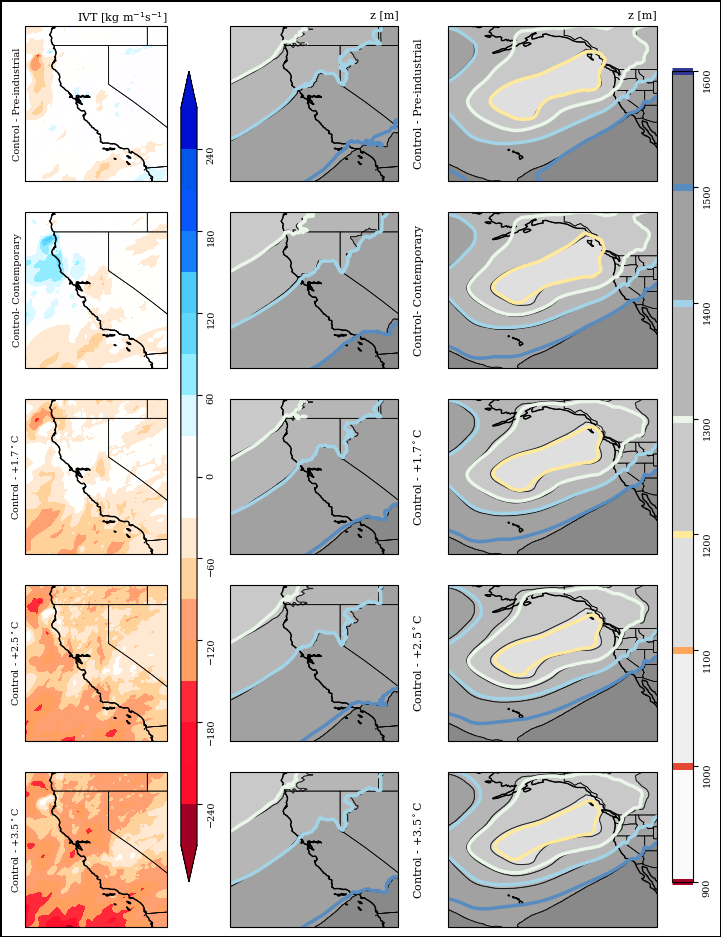

In [20]:
%%time
i=0
fig = plot_z_dIVT(ds, start_dates[i])
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/dIVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

CPU times: user 18.4 s, sys: 660 ms, total: 19 s
Wall time: 18.5 s


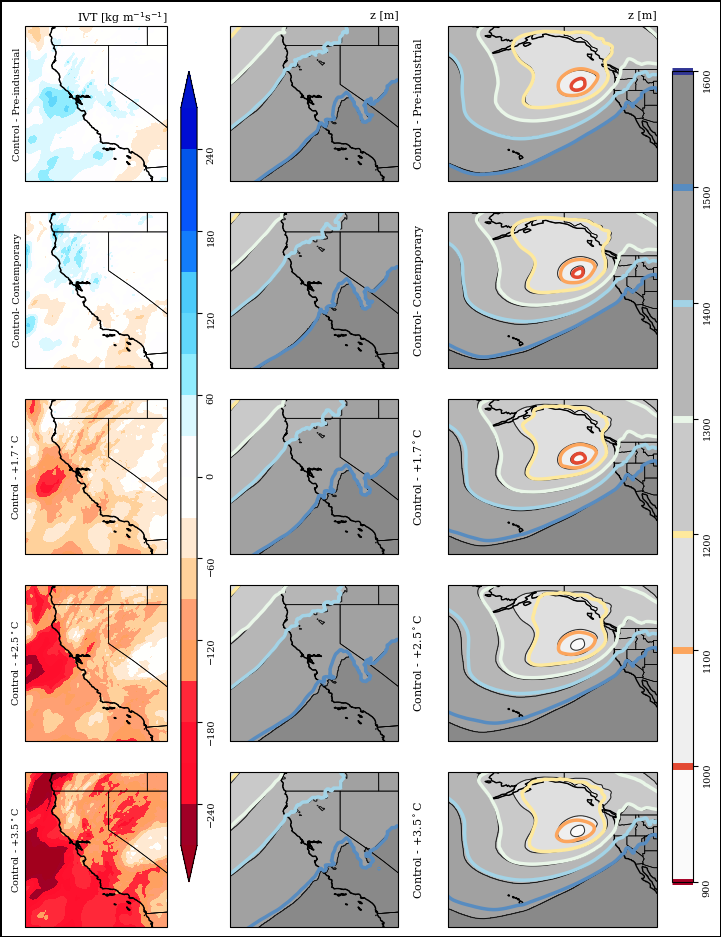

In [21]:
%%time
i=1
fig = plot_z_dIVT(ds, start_dates[i])
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/dIVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

CPU times: user 18.7 s, sys: 680 ms, total: 19.4 s
Wall time: 18.9 s


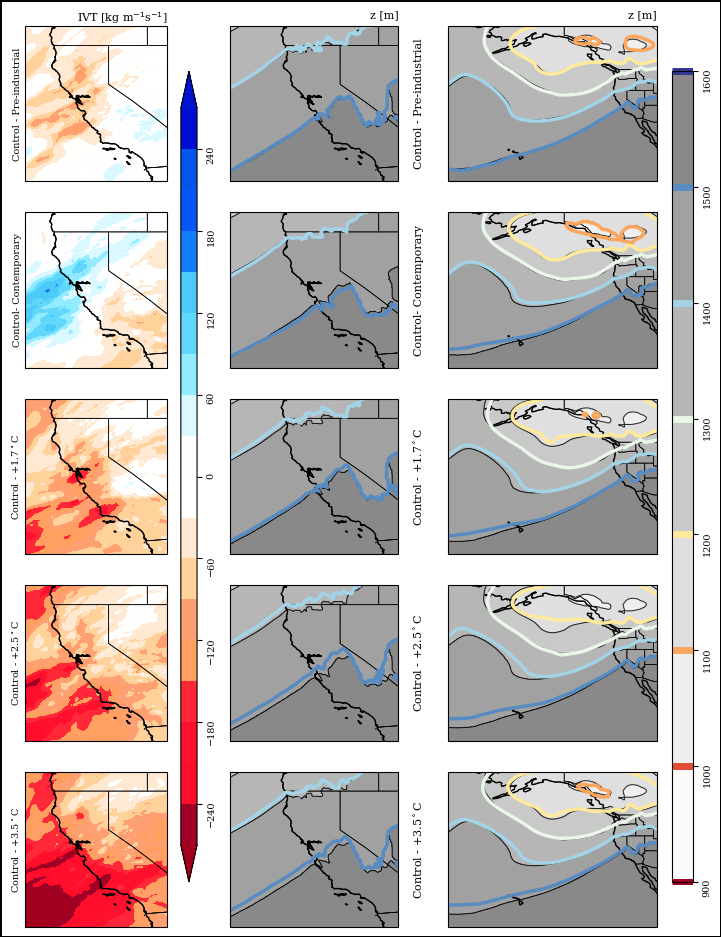

In [22]:
%%time
i=2
fig = plot_z_dIVT(ds, start_dates[i])
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/dIVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

CPU times: user 19.3 s, sys: 677 ms, total: 20 s
Wall time: 19.8 s


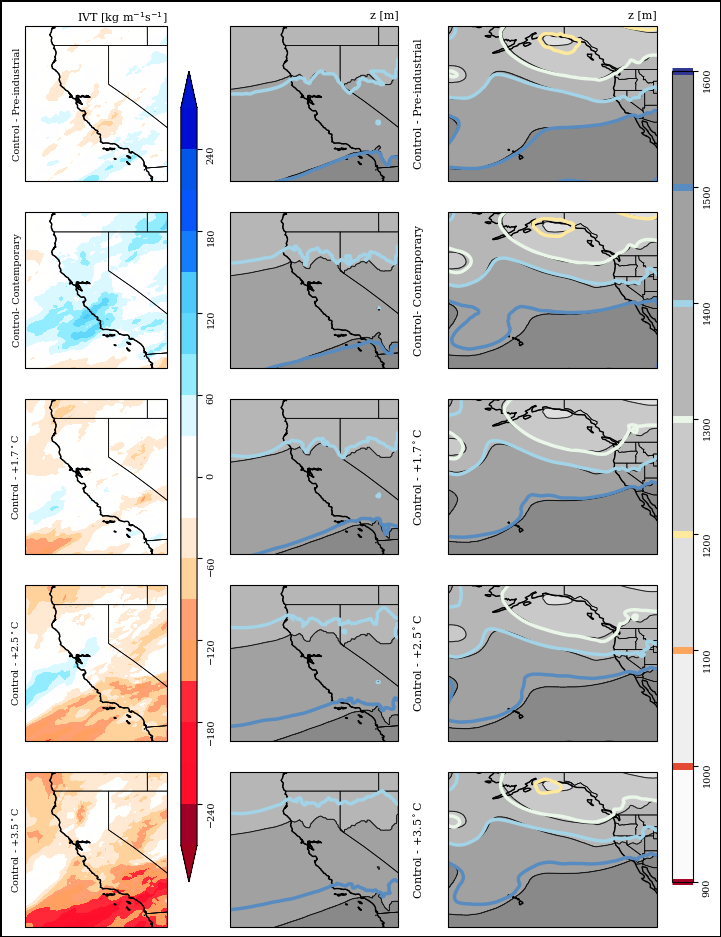

In [23]:
%%time
i=3
fig = plot_z_dIVT(ds, start_dates[i])
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/dIVT_Z_{}.png".format(ts), dpi=300, bbox_inches="tight")

### SBJ transects (U,V)

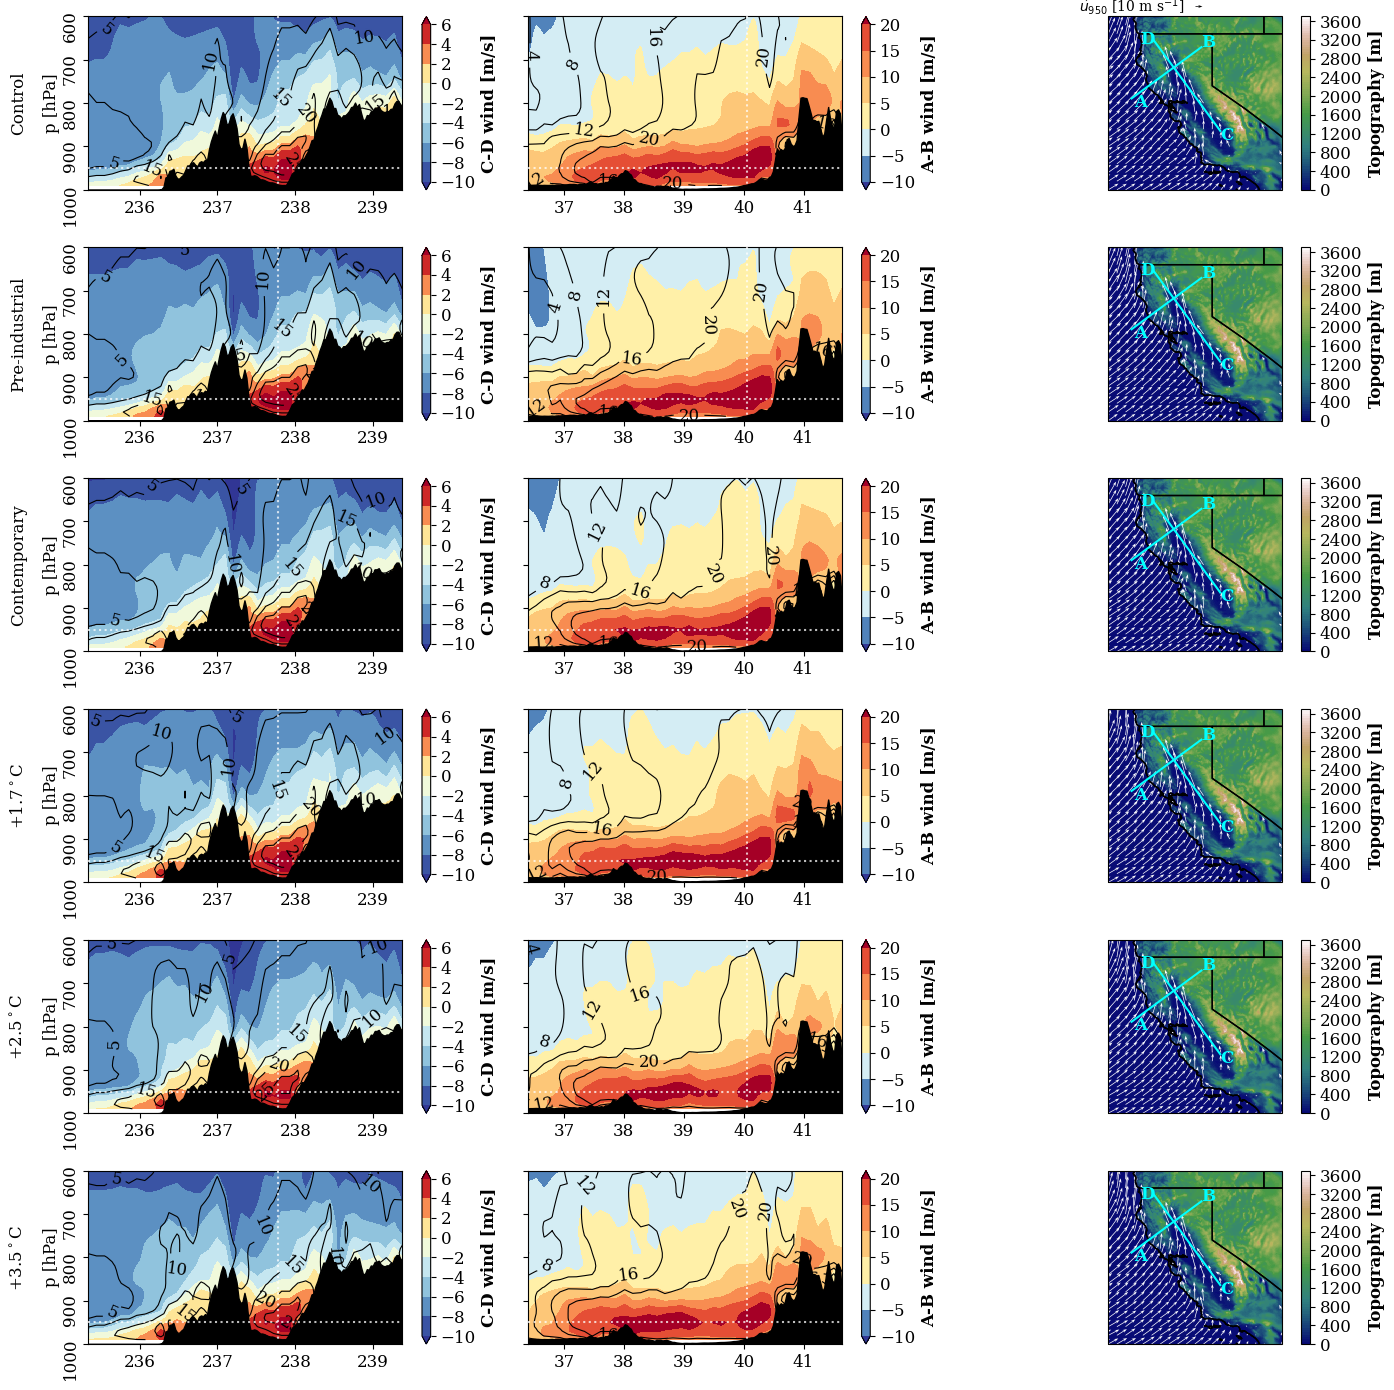

In [24]:
i=0
fig = plot_along_across_transect(ds, date=start_dates[i], fs=12, figsize=(14,14), skip=4)
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_{}.png".format(ts), dpi=300, bbox_inches="tight")

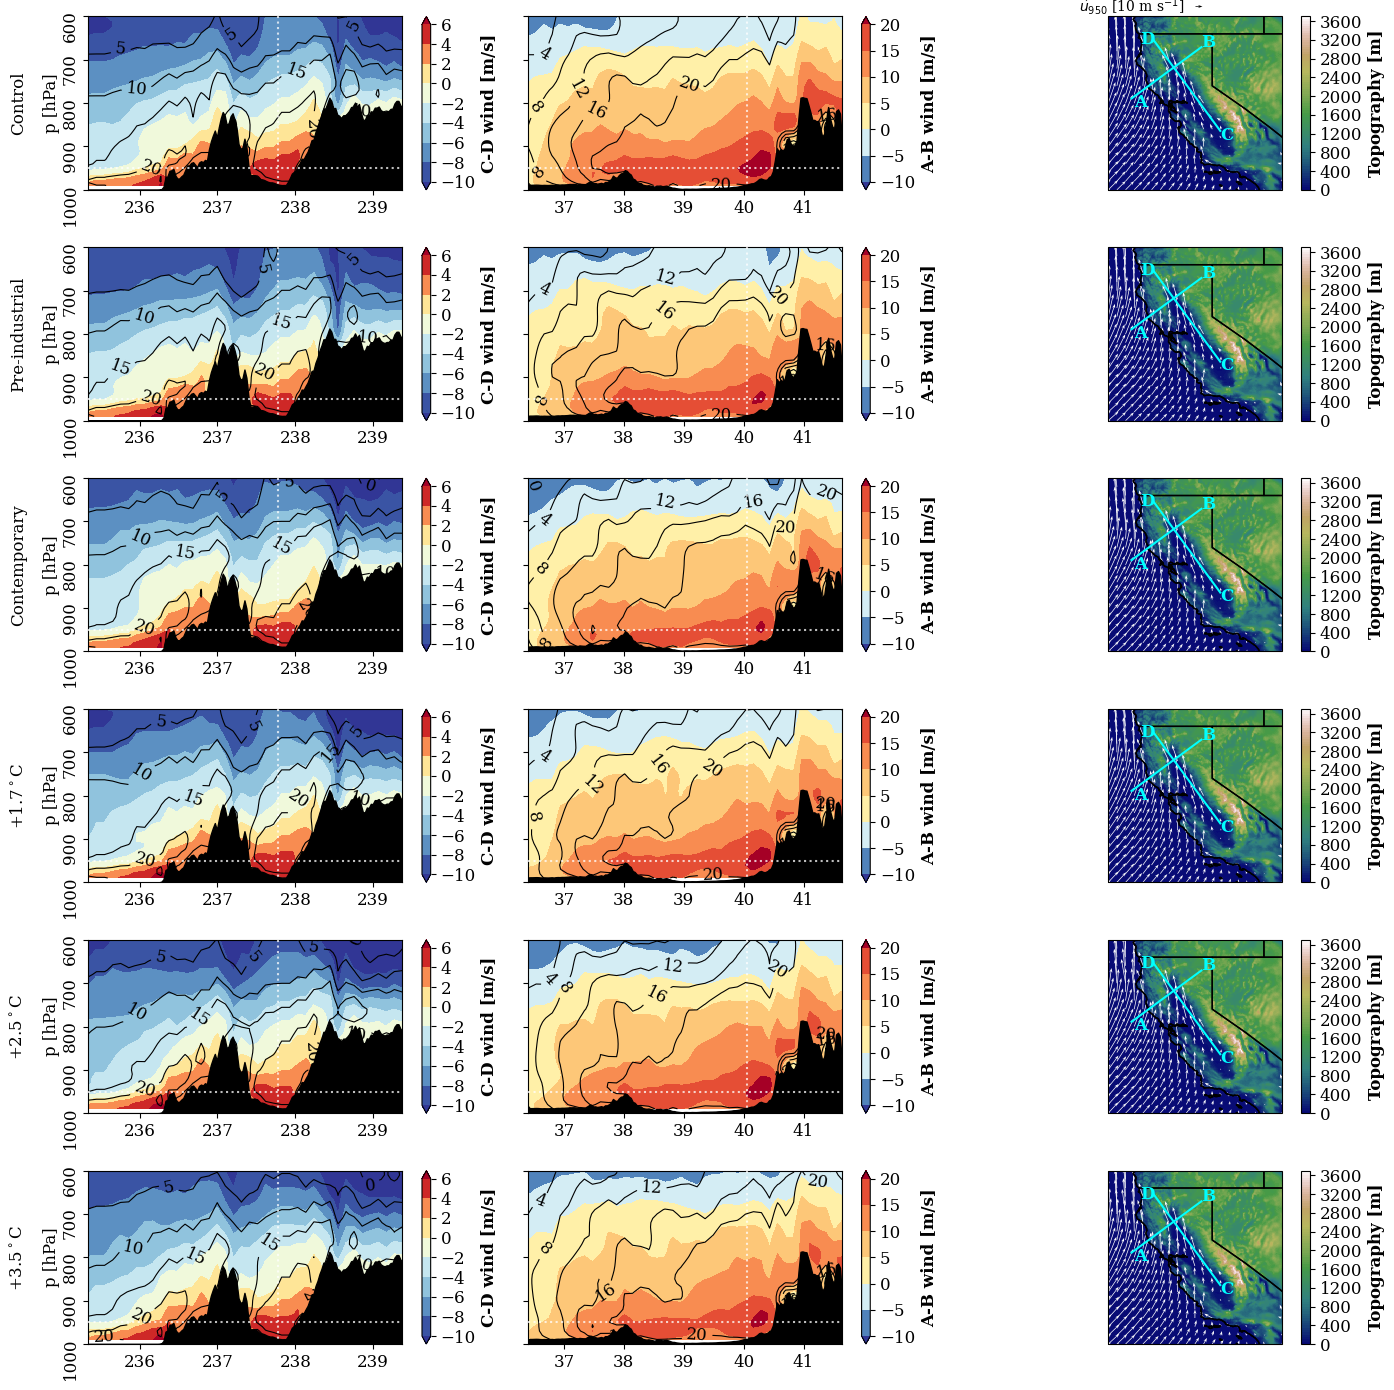

In [25]:
i=1
fig = plot_along_across_transect(ds, date=start_dates[i], fs=12, figsize=(14,14), skip=4)
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_{}.png".format(ts), dpi=300, bbox_inches="tight")

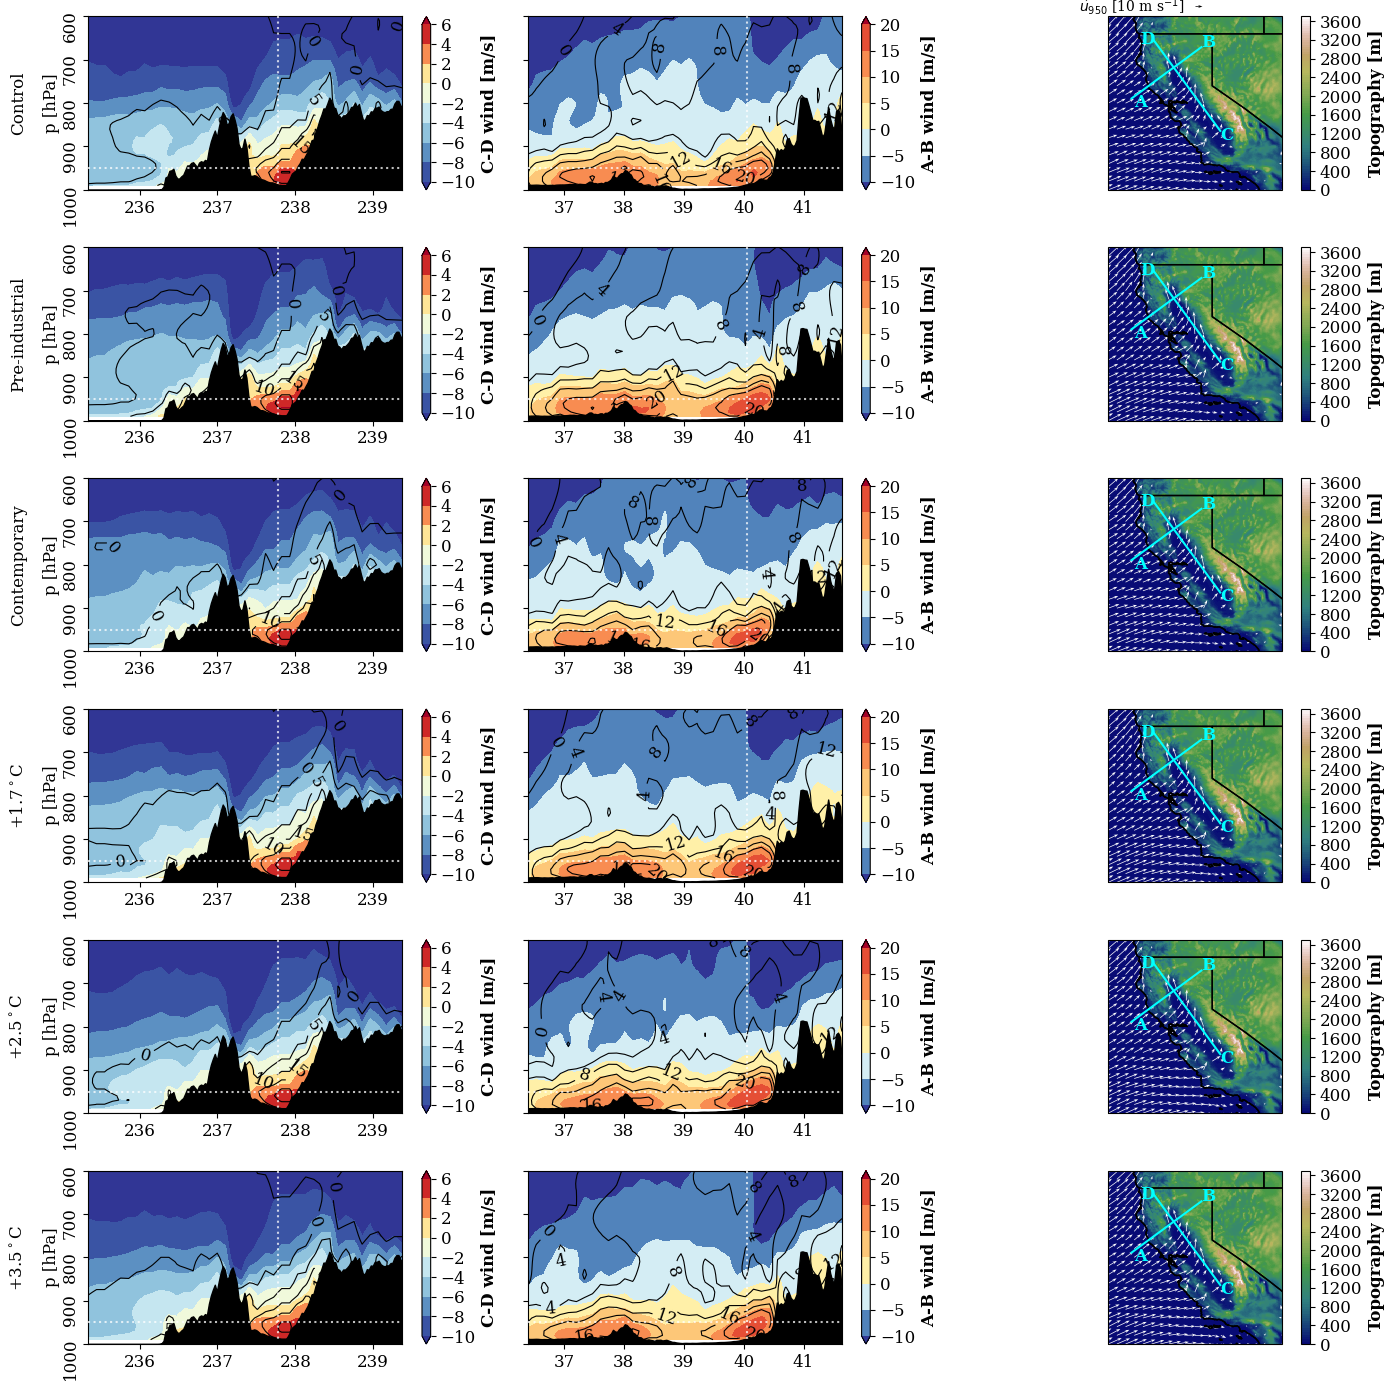

In [26]:
i=2
fig = plot_along_across_transect(ds, date=start_dates[i], fs=12, figsize=(14,14), skip=4)
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_{}.png".format(ts), dpi=300, bbox_inches="tight")

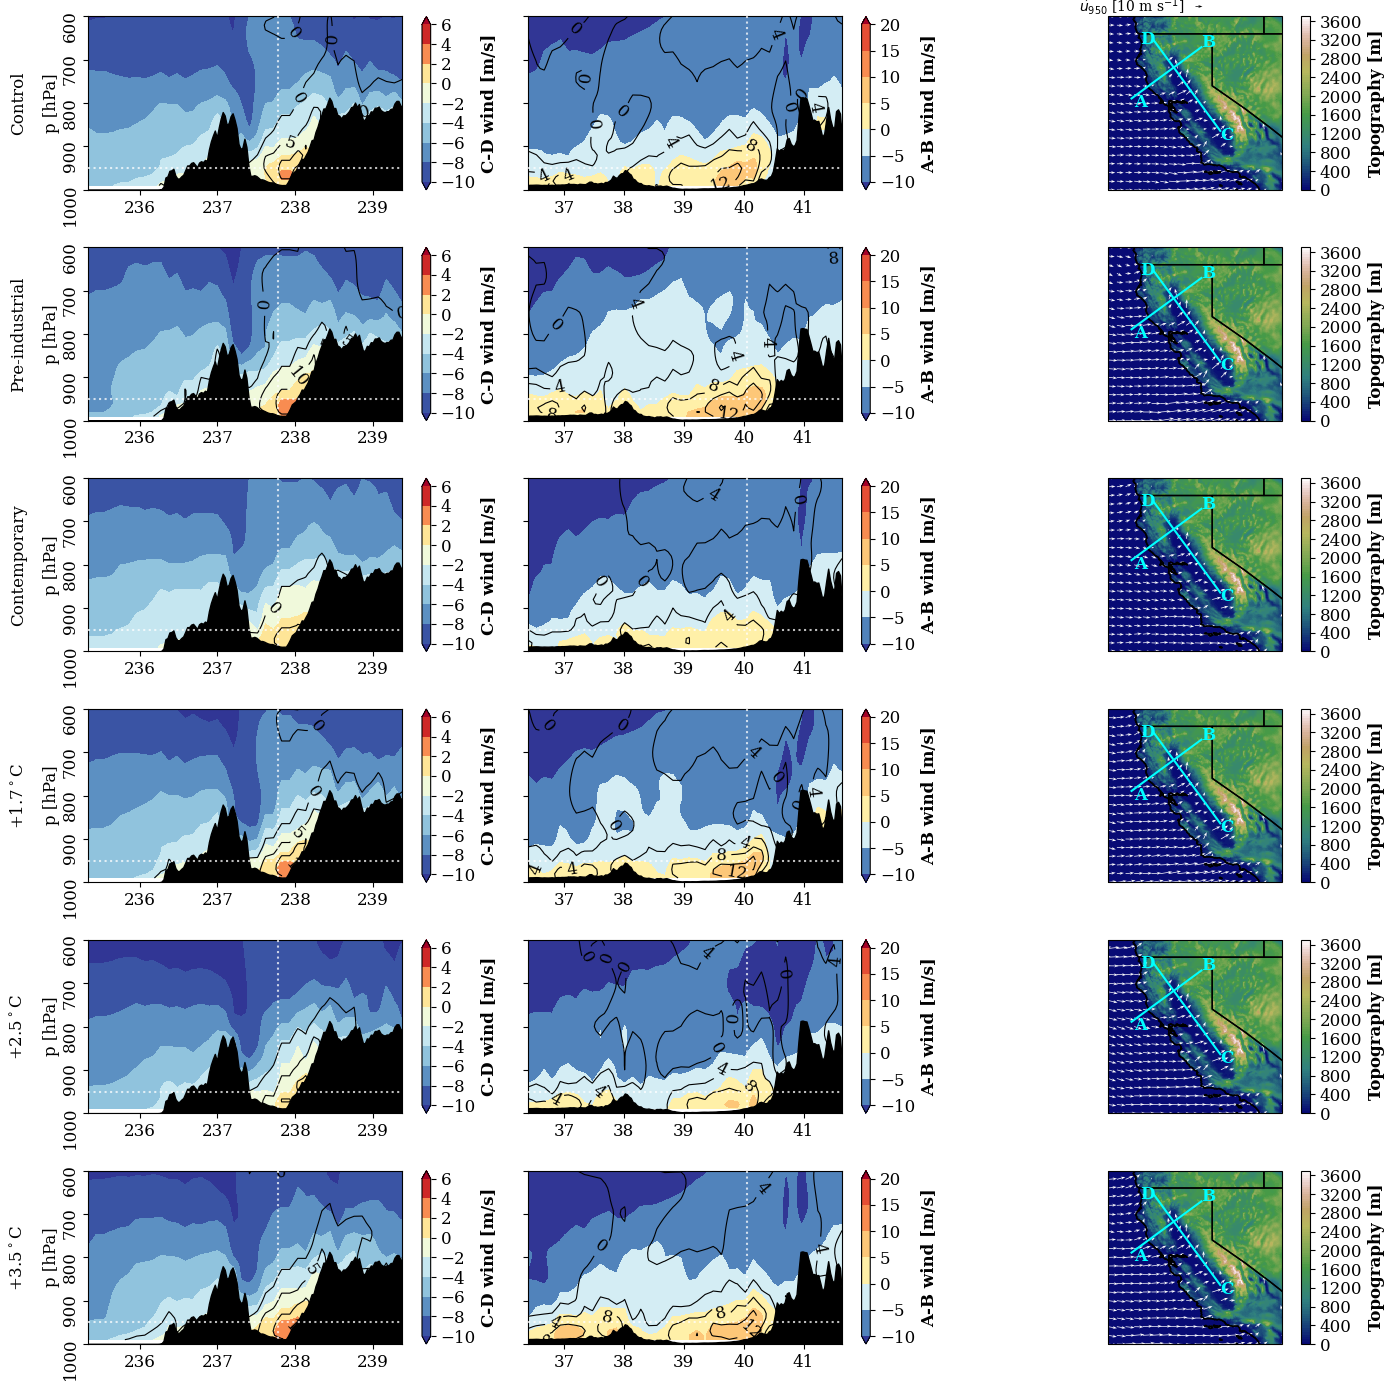

In [27]:
i=3
fig = plot_along_across_transect(ds, date=start_dates[i], fs=12, figsize=(14,14), skip=4)
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_{}.png".format(ts), dpi=300, bbox_inches="tight")

### SBJ vertical profiles

## Vertical profiles


### Colors.  

- RRM-E3SM (3.5km) as dark blue.  
- RRM-E3SM (7 km) will now be green (RGB - 3,250,8; #03FA08).  
- RRM-E3SM (14km) will now be cyan (RGB - 180,218,233; #B4DAE9)

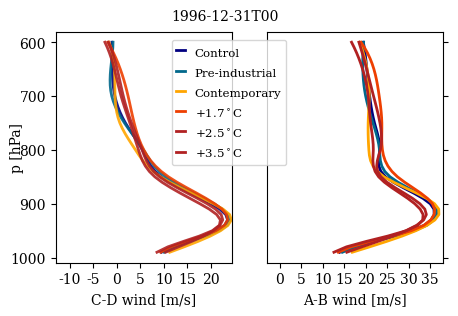

In [28]:
i=0
Along,Across = create_AA(ds, date=start_dates[i])
fig = plot_profile(Along, Across, date=start_dates[i], labels=labels, fs=10)
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/UV_profiles_{}.png".format(str(Along[-1].time.values).split(":")[0].replace(" ","T")), dpi=300, bbox_inches="tight")

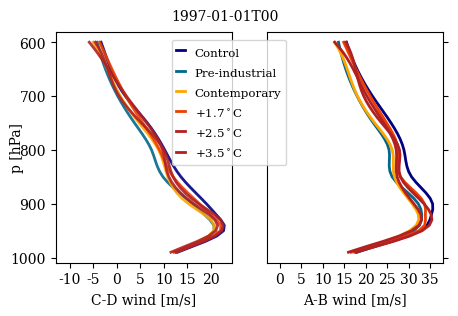

In [29]:
i=1
Along,Across = create_AA(ds, date=start_dates[i])
fig = plot_profile(Along, Across, date=start_dates[i], labels=labels, fs=10)
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/UV_profiles_{}.png".format(str(Along[-1].time.values).split(":")[0].replace(" ","T")), dpi=300, bbox_inches="tight")

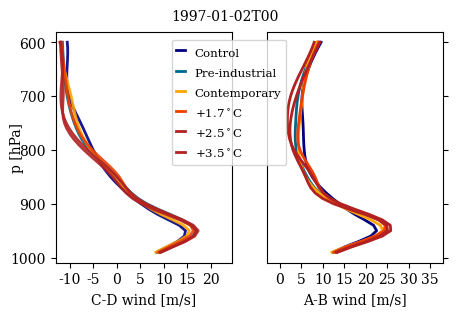

In [30]:
i=2
Along,Across = create_AA(ds, date=start_dates[i])
fig = plot_profile(Along, Across, date=start_dates[i], labels=labels, fs=10)
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/UV_profiles_{}.png".format(str(Along[-1].time.values).split(":")[0].replace(" ","T")), dpi=300, bbox_inches="tight")

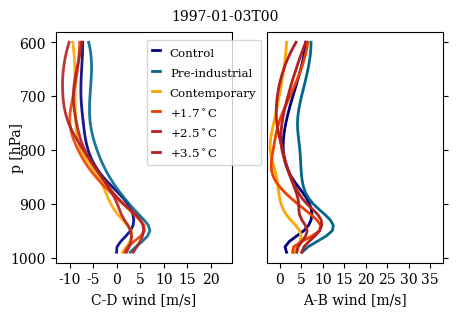

In [31]:
i=3
Along,Across = create_AA(ds, date=start_dates[i])
fig = plot_profile(Along, Across, date=start_dates[i], labels=labels, fs=10, move=True)
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/UV_profiles_{}.png".format(str(Along[-1].time.values).split(":")[0].replace(" ","T")), dpi=300, bbox_inches="tight")

### SBJ transects differences with Control run (U,V)

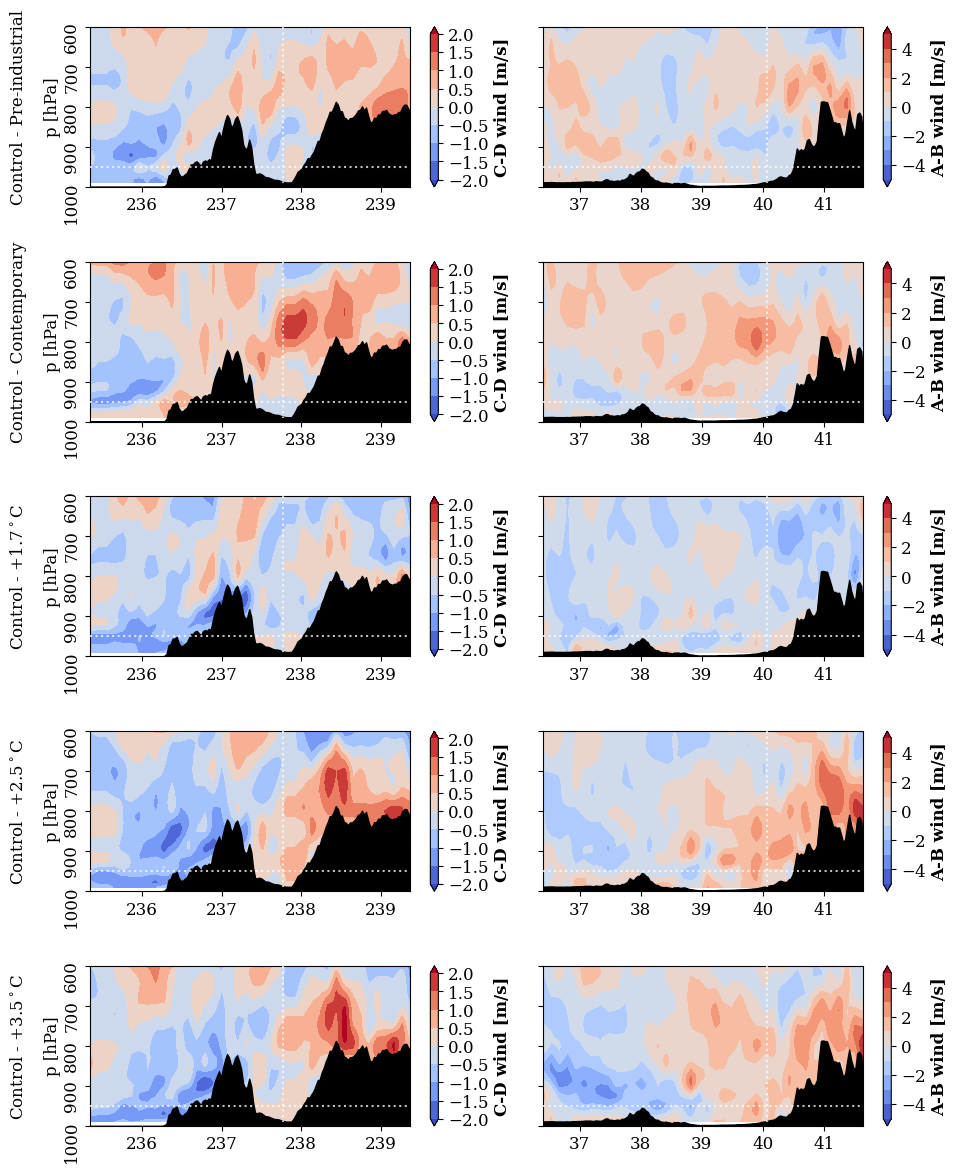

In [32]:
i=0
fig = plot_along_across_transect_diff(ds, date=start_dates[i], fs=12, figsize=(14,14))
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_diff_{}.png".format(ts), dpi=300, bbox_inches="tight")

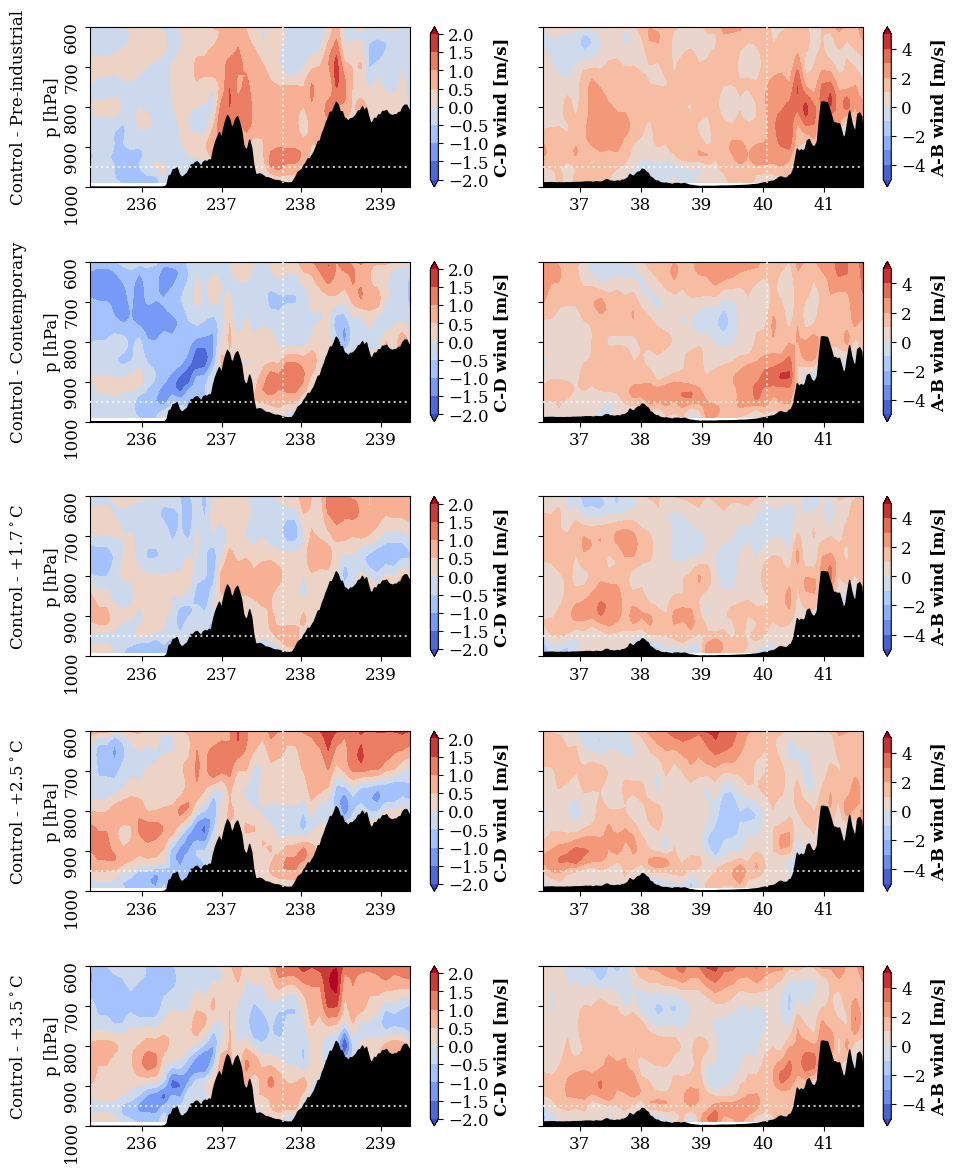

In [33]:
i=1
fig = plot_along_across_transect_diff(ds, date=start_dates[i], fs=12, figsize=(14,14))
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_diff_{}.png".format(ts), dpi=300, bbox_inches="tight")

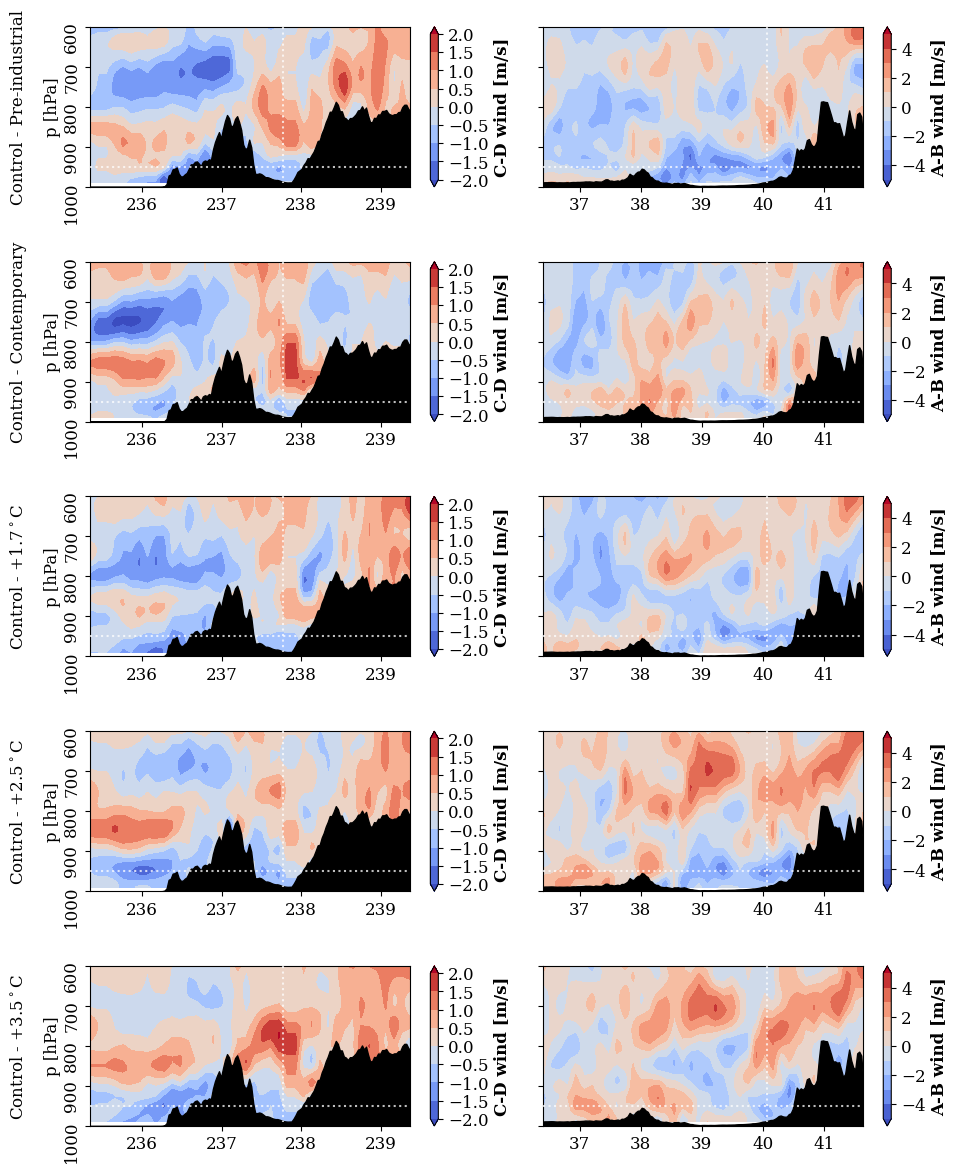

In [34]:
i=2
fig = plot_along_across_transect_diff(ds, date=start_dates[i], fs=12, figsize=(14,14))
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_diff_{}.png".format(ts), dpi=300, bbox_inches="tight")

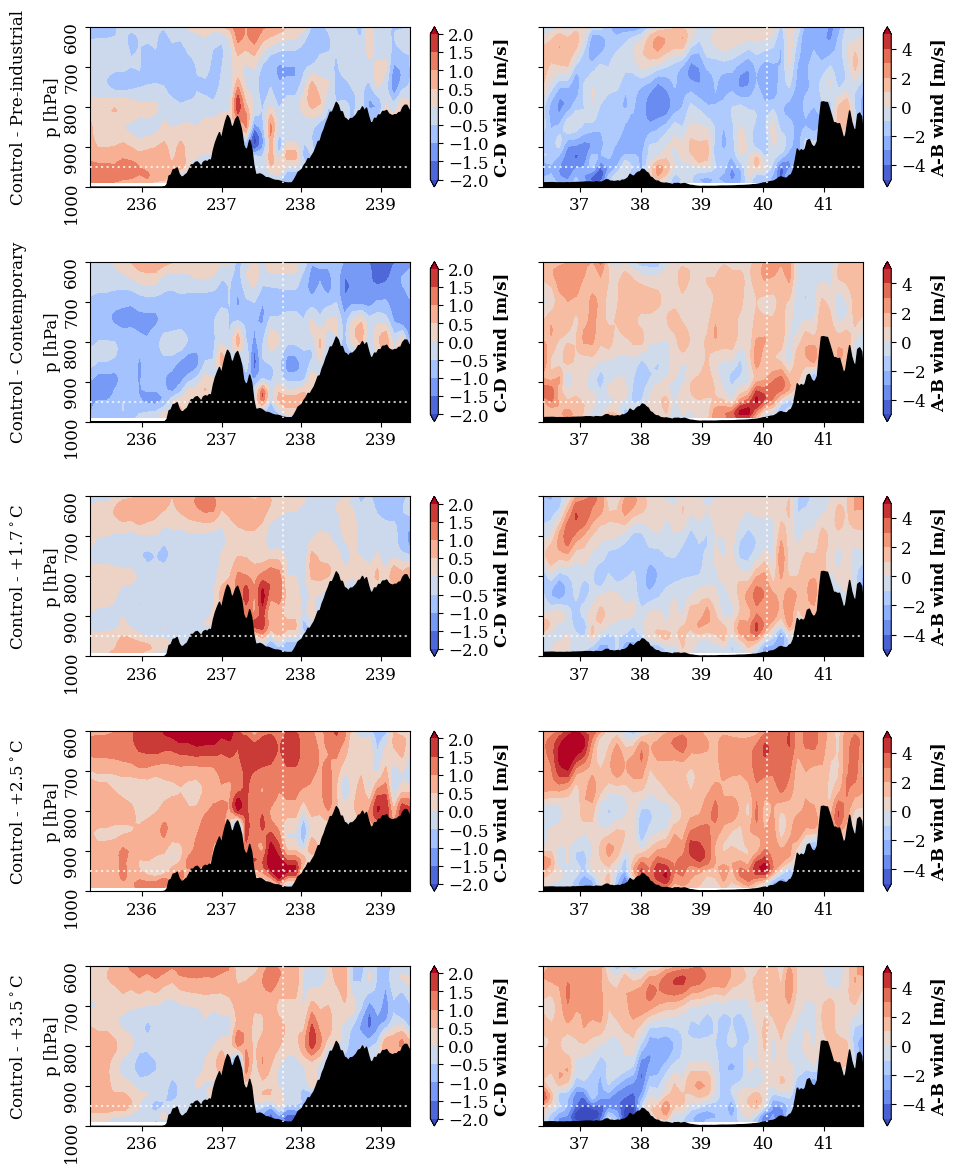

In [35]:
i=3
fig = plot_along_across_transect_diff(ds, date=start_dates[i], fs=12, figsize=(14,14))
fig.tight_layout()
ts =  np.datetime_as_string(np.datetime64(start_times[i])).split(":")[0]
fig.savefig("plots/Cross_section_diff_{}.png".format(ts), dpi=300, bbox_inches="tight")